# Polscope phase large data processer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from numpy.fft import fft2, ifft2, fftshift, ifftshift

import sys
import glob
from PIL import Image
from skimage import io
import pickle
import os
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import waveorder as wo

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


In [2]:
#Reading files using optimized method (according to IO Speeds notebook from czbiohub/virusLifecycle).
def optimizedReading(img_paths):
    """This function takes in a list of image paths i.e. ["../path1, ../path2"] 
    and reads each image into a numpy array."""
    
    length = len(img_paths)
    empty = np.empty((length, 2048, 2048), dtype = 'uint16')
    
    for num, img in zip(np.arange(length), img_paths):
        empty[num,:,:] = io.imread(img)
    
    return empty

In [3]:
#Adapted from Li-Hao's visual.py
def hyper_stack_viewer(image_stack, slices, time, size=(10,10), colormap='gray'):
    
    '''
    Visualize xyzt stacks.
    image_stack: Stack of images in xyzt order 
    slices: the number of slices
    time: the number of timepoints
    Example data: 
        [imgz0t0, imgz1t0, img z2t0, imgz0t1, imgz1t1, img z2t1]
        slices = 3
        time = 2
    '''
    
    max_val = np.percentile(image_stack, 99.9)
    min_val = np.min(image_stack)

    def interact_plot_4D(z, t):    
        plt.figure(figsize=size)
        plt.imshow(image_stack[t*slices + z],cmap=colormap, vmin=min_val, vmax=max_val)
        plt.colorbar()
    
    return interact(interact_plot_4D, z=widgets.IntSlider(value=0, min=0, max=slices, step=1),
                    t=widgets.IntSlider(value=0, min=0, max=time, step=1))

In [4]:
n_media       = 1.512                   # refractive index of the immersed media for objective (oil: 1.512, water: 1.33, air: 1)
lambda_illu   = 0.532               # illumination wavelength (um)
mag           = 63                  # magnification of the microscope                      
NA_obj        = 1.47                # detection NA of the objective
NA_illu       = 0.9                 # illumination NA of the condenser
N_defocus     = 21                   # number of defocus images
N_channel     = 5                   # number of Polscope channels
z_step        = 0.25               # z_step of the stack
z_defocus     = -(np.r_[:N_defocus]-N_defocus//2)*z_step
z_defocus += 1
chi           = 0.03*2*np.pi        # swing of the LC
ps            = 6.45/mag            # effective pixel size at the sample plane (cam pix/mag in um)
cali          = True                # correction for S1/S2 Polscope reconstruction (does not affect phase)
bg_option     = 'local_fit'         # background correction method for Polscope recon (does not affect phase)
data_path     = '/mnt/comp_micro/SpinningDisk/RawData/virtualstaining/2019_04_08_U2OS_plin2/2019_04_08_U2OS_plin2_Lipid_MT_Actin_3/2-Pos_001_002/' # data path
bg_path       = '/mnt/comp_micro/SpinningDisk/RawData/virtualstaining/2019_04_08_U2OS_plin2/BG_2019_0408_1412_1/Pos0/'# background data path
output_path   = '/mnt/comp_micro/Projects/nucleolus/labelfree_segmentation/phase_recon/'# output image path


In [5]:
z_defocus

array([ 3.5 ,  3.25,  3.  ,  2.75,  2.5 ,  2.25,  2.  ,  1.75,  1.5 ,
        1.25,  1.  ,  0.75,  0.5 ,  0.25,  0.  , -0.25, -0.5 , -0.75,
       -1.  , -1.25, -1.5 ])

In [6]:
# solver option

deconv = 'TV'         # deconvolution method

if deconv == 'Tikhonov':
    reg_u = 1e-1      # absorption regularizer (larger the smoother but less contrast)
    reg_p = 1e-3      # phase regularizer
    
elif deconv == 'TV':
    lambda_u = 1e-2   # absorption regularizer
    lambda_p = 1e-2   # phase regularizer
    rho = 1.5         # rho coefficient of ADMM algorithm (the larger the less noisy and contrast)
    itr = 10          # number of ADMM iteration (10 is usually good)
    verbose = False   # report of the iteration number or not

In [7]:
# Plot setting

max_phase = 2.5                      # maximum phase value to display
min_phase = -1.5                     # minimum phase value to display

max_ret   = 2e-3/lambda_illu*2*np.pi # maximum retardance value
all_z     = True                    # plot all z birefringence or not
z_layer   = 0                        # focal layer to plot if only plot single layer
recon_birefringence = False

In [8]:
filedir = data_path + '*PolState*.tif'
filedir_bg = bg_path + '*Acquired*.tif'
files = sorted(glob.glob(filedir), key=wo.numericalSort)
files_bg = sorted(glob.glob(filedir_bg), key=wo.numericalSort)

In [9]:
#N_z*N_channels should match the number of files
assert len(files) == N_defocus*N_channel
# Only 5 background images for Polstates 0-4 are needed.
assert len(files_bg) == 5
# Background images should not be cropped.
#assert all(io.imread(files_bg[i]).shape == (2048,2048) for i in range(5))

In [10]:
#Visualizing one channel just to find the right z-defocus
stack = optimizedReading(files[0:21])

In [12]:
z_defocus

array([ 3.5 ,  3.25,  3.  ,  2.75,  2.5 ,  2.25,  2.  ,  1.75,  1.5 ,
        1.25,  1.  ,  0.75,  0.5 ,  0.25,  0.  , -0.25, -0.5 , -0.75,
       -1.  , -1.25, -1.5 ])

In [11]:
hyper_stack_viewer(stack, 21, 0, size = (10,10))

interactive(children=(IntSlider(value=0, description='z', max=21), IntSlider(value=0, description='t', max=0),…

<function __main__.hyper_stack_viewer.<locals>.interact_plot_4D(z, t)>

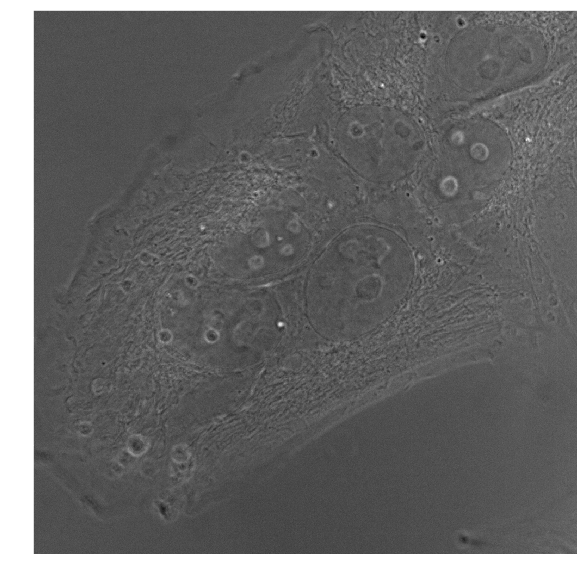

In [13]:
#select a FOV for processing

Ns = 1000
Ms = 1000
n_start = [250, 250] # grating target


plt.figure(figsize=(10,10))
plt.imshow(io.imread(files[15]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms], cmap = 'gray')


In [45]:
%time
setup = wo.waveorder_microscopy((Ns,Ms), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi,\
                                n_media=n_media, cali=cali, bg_option=bg_option)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.5 µs


In [21]:
os.system('mkdir '+output_path)
os.system('mkdir '+output_path+'phase')
os.system('mkdir '+output_path+'birefringence')

0

In [46]:
Nimg = N_defocus*N_channel
N_time = len(files)//Nimg
#print(Nimg,N_time)

# Load background images
Nbg = len(files_bg)
I_bg_pre = []

for i in range(0, Nbg):
    Itemp = io.imread(files_bg[i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
    I_bg_pre.append(Itemp)
    sys.stdout.write("\r" + "Loaded Background " + str(i))
    sys.stdout.flush()
    
I_bg_pre = np.array(I_bg_pre)

I_bg = np.zeros_like(I_bg_pre)
I_bg = wo.intensity_mapping(I_bg_pre)



for m in range(N_time):
    
    # Load Polscope images
    I_meas_pre =[]

    for i in range(0, Nimg):
        Itemp = io.imread(files[m*Nimg+i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
        I_meas_pre.append(Itemp)
        sys.stdout.write("\r" + "Loaded Polscope image " + str(i))
        sys.stdout.flush()
        
    I_meas_pre = np.array(I_meas_pre)
    I_meas_pre = np.transpose(I_meas_pre.reshape((N_channel, N_defocus, Ns, Ms)), (0,2,3,1))
    
    # intensity mapping to match the theory
    I_meas = np.zeros_like(I_meas_pre)
    for i in range(N_defocus):
        I_meas[:,:,:,i] = wo.intensity_mapping(I_meas_pre[:,:,:,i])
        sys.stdout.write("\r" + "Intensity mapping " + str(i))
        sys.stdout.flush()
    
    
    # Stokes vector recon with bg correction
    S_image_recon = setup.Stokes_recon(I_meas)
    S_bg_recon = setup.Stokes_recon(I_bg)
    S_image_tm = setup.Stokes_transform(S_image_recon)
    S_bg_tm = setup.Stokes_transform(S_bg_recon)
    S_image_tm = setup.Polscope_bg_correction(S_image_tm, S_bg_tm)    
    Recon_para = setup.Polarization_recon(S_image_tm)
    
    # Take out S0 for phase reconstruction
    S0_stack = S_image_tm[0].copy()
    
    
    # Phase reconstruction. Trying different regularizers.
    for mu in [1e-2]:
        if deconv == 'Tikhonov':
            mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='Tikhonov', reg_u = mu, reg_p = reg_p)

        elif deconv == 'TV':
            mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='TV', lambda_u = mu, lambda_p = lambda_p, \
                                                      itr = itr, rho=rho, verbose = verbose)


        # figure plotting as tiff files
        file_name_phase = output_path+'phase/'+files[0].split('State')[0].rsplit('/')[-1]+str(mu)+'phase.tiff'
        plt.imsave(file_name_phase, phi_sample, format="tiff", cmap=plt.cm.gray, vmin=min_phase, vmax=max_phase)
    
    if all_z == True:
        for i in range(N_defocus):

            bi_hsv = np.transpose(np.array([Recon_para[1,:,:,i]/np.pi, \
                                               np.ones((Ns,Ms)), \
                                               np.clip(Recon_para[0,:,:,i]/max_ret,0,1)]), (1,2,0))
            bi_rgb = hsv_to_rgb(bi_hsv.copy())


            file_name_bire = output_path+'birefringence/'+files[m*Nimg+i].split('State0')[0].split('/')[1]\
                            +files[m*Nimg+i].split('State0')[1].split('.')[0]+'_birefringence.tiff'
            plt.imsave(file_name_bire, bi_rgb, format="tiff")
    
    elif recon_birefringence == True:
#             bi_hsv = np.transpose(np.array([Recon_para[1,:,:,z_layer]/np.pi, \
#                                                np.ones((Ns,Ms)), \
#                                                np.clip(Recon_para[0,:,:,z_layer]/max_ret,0,1)]), (1,2,0))
            norm_phase = np.clip(phi_sample, min_phase, max_phase)-min_phase
            norm_phase /= np.max(norm_phase)
            bi_hsv = np.transpose(np.array([Recon_para[1,:,:,z_layer]/np.pi, \
                                               np.clip(Recon_para[0,:,:,z_layer]/max_ret,0,1), \
                                               norm_phase]), (1,2,0))
            bi_rgb_temp = hsv_to_rgb(bi_hsv.copy())
            bi_rgb = np.zeros_like(bi_rgb_temp)
            bi_rgb[:,:,0] = bi_rgb_temp[:,:,2]
            bi_rgb[:,:,1] = bi_rgb_temp[:,:,1]
            bi_rgb[:,:,2] = bi_rgb_temp[:,:,0]


            file_name_bire = output_path+'birefringence/'+files[m*Nimg+z_layer].split('State0')[0].rsplit('/')[-1]\
                            +files[m*Nimg+z_layer].split('State0')[1].split('.')[0]+'_birefringence.tiff'
            plt.imsave(file_name_bire, bi_rgb, format="tiff")


    
    print('Number of image stacks processed (%d / %d)'%(m+1,N_time))

Intensity mapping 20e 104Number of image stacks processed (1 / 1)
